In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.ensemble.weight_boosting import AdaBoostClassifier
# from sklearn.linear_model.ridge import RidgeClassifierCVclear
# from sklearn.linear_model.ridge import RidgeClassifier
# from sklearn.ensemble.bagging import BaggingClassifier
# from sklearn.ensemble.forest import ExtraTreesClassifier
# from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost.sklearn import XGBClassifier 


# survival	Survival	0 = No, 1 = Yes
# pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
# sex	Sex	
# Age	Age in years	
# sibsp	# of siblings / spouses aboard the Titanic	
# parch	# of parents / children aboard the Titanic	
# ticket	Ticket number	
# fare	Passenger fare	
# cabin	Cabin number	
# embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

/home/ds_magico/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.gradient_boosting module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/ds_magico/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.weight_boosting module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
train = pd.read_csv('./train.csv')
test =  pd.read_csv('./test.csv')

data = [train, test]
df_1 = pd.concat(data)
df_1 = df_1.reset_index()
df_1 = df_1.drop(columns='index')

/home/ds_magico/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


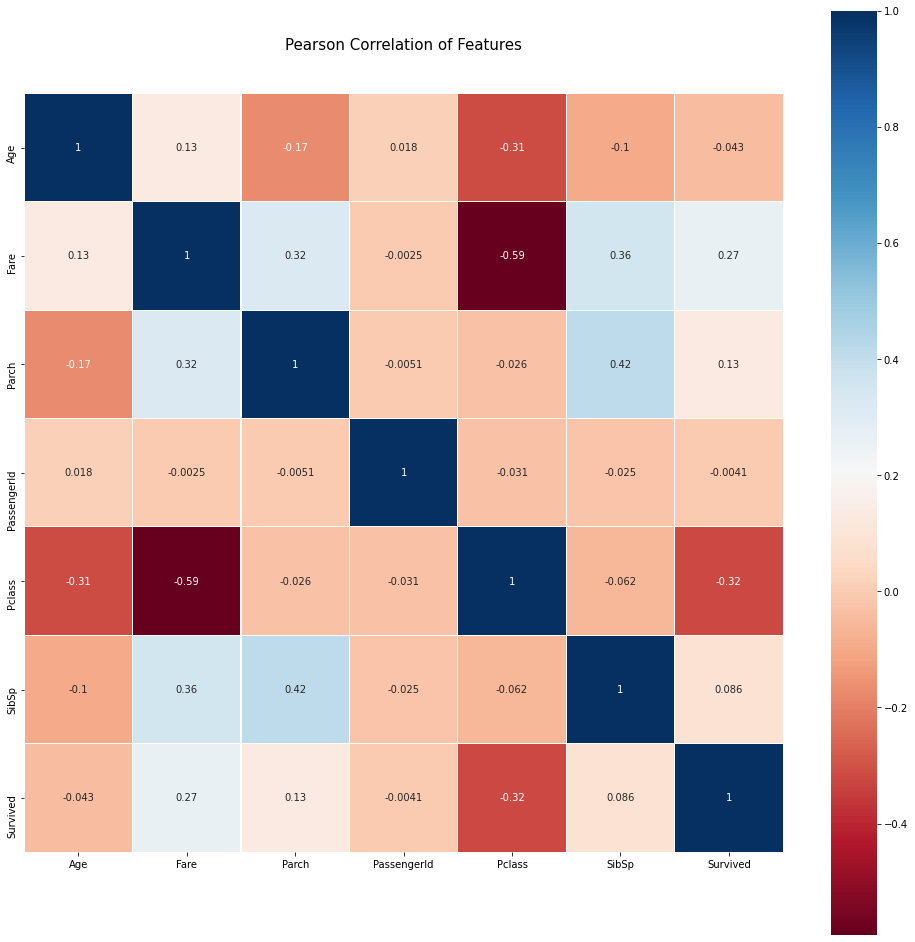

In [3]:
colormap = plt.cm.RdBu
plt.figure(figsize=(17,17))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df_1.corr(method='kendall') ,linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

# - Clean Data

In [4]:
def clean(df):
    
    df = pd.DataFrame(df)
    df.Embarked = [ 0 if i == 'S' else 1 if i == 'C' else 2 for i in df.Embarked]
    df[df.Embarked.isna()].Embarked = int(df.Embarked.mean())
    
    df.loc[df['Fare'].isna(), 'Fare'] = df.Fare.mean()
    
#     df.loc[ df['Fare'] <= 7.91, 'Fare'] 						        = 0
#     df.loc[(df['Fare'] > 7.91) & (df['Fare'] <= 14.454), 'Fare'] = 1
#     df.loc[(df['Fare'] > 14.454) & (df['Fare'] <= 31), 'Fare']   = 2
#     df.loc[ df['Fare'] > 31, 'Fare'] 							        = 3
#     df['Fare'] = df['Fare'].astype(int)
    
#     df.Fare = [np.intc(float(str(round(value, 5)).replace('.', ''))) for value in df.Fare]
    df.Sex = [1 if i == "male" else 0 for i in df.Sex]
    
    return df
    
df_2 = clean(df_1)
test_1 = clean(test)

In [5]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1309 non-null int64
Fare           1309 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null int64
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(6), object(3)
memory usage: 122.8+ KB


In [6]:
df_2.describe()

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived
count,1046.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,0.397250,33.295479,0.385027,655.000000,2.294882,0.644003,0.498854,0.383838
std,14.413493,0.656321,51.738879,0.865560,378.020061,0.837836,0.478997,1.041658,0.486592
min,0.170000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,21.000000,0.000000,7.895800,0.000000,328.000000,2.000000,0.000000,0.000000,0.000000
50%,28.000000,0.000000,14.454200,0.000000,655.000000,3.000000,1.000000,0.000000,0.000000
75%,39.000000,1.000000,31.275000,0.000000,982.000000,3.000000,1.000000,1.000000,1.000000
max,80.000000,2.000000,512.329200,9.000000,1309.000000,3.000000,1.000000,8.000000,1.000000


# - Cabin Columns

In [7]:
def clean_cabin(df, drop, na):
    df = pd.DataFrame(df)
    
    if (na == 1):
        df_cabin = df[~df.Cabin.isna()]
        df_cabin.Cabin = [ord(i[0]) - 65 if type(i) != float else int(i) - 28 for i in df_cabin.Cabin]
        df_cabin.Cabin = [ 0 if i in [0, 1, 2] else 1 for i in df_cabin.Cabin]
    else:
        df_cabin = df[df.Cabin.isna()]

    y = df_cabin.Cabin
    x = df_cabin.drop(columns=drop)
    
    return [x, y]
    
def predict_cabin(df, test=0):
    df = pd.DataFrame(df)
    
    # Trein DataSet -> pd.read_csv('./train.csv')
    # Cleaning DataSet
    drop_train = ['PassengerId', 'Survived', 'Ticket', 'Age', 'Name', 'Cabin']
    x_train, y_train = clean_cabin(df, drop_train, 1)  
    
    # Predict train DataSet
    x_train_aux, x_test_aux, y_train_aux, y_test_aux = train_test_split(x_train, y_train, test_size=0.30, random_state=337)
    clf = GradientBoostingClassifier()
    clf.fit(x_train_aux, y_train_aux)
    y_pred = clf.predict(x_test_aux)

    # Predict test DataSet
    x_df_train, y_df_train = clean_cabin(df, drop_train, 0)  
    df_train = clf.predict(x_df_train) 
    
    # Predict final DataSet -> pd.read_csv('./test.csv')
    drop_test = ['PassengerId', 'Ticket', 'Age', 'Name', 'Cabin']
    x_df_test, y_df_test = clean_cabin(test, drop_test, 0)
    df_test = clf.predict(x_df_test)
    
    # join DataSet
    df.loc[~df['Cabin'].isna(), 'Cabin'] = y_train
    df.loc[df['Cabin'].isna(), 'Cabin'] = df_train
    
    useless, y_notna = clean_cabin(test, drop_test, 1)
    test.loc[~test['Cabin'].isna(), 'Cabin'] = y_notna
    test.loc[test['Cabin'].isna(), 'Cabin'] = df_test

    print(accuracy_score(y_pred,y_test_aux ))
    
    return [df, test]
    
df_3, test_2 = predict_cabin(df_2, test_1)

0.898876404494382


/home/ds_magico/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/home/ds_magico/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


# - AGE Column

### Data cleaning AGE

In [8]:
Miss = [int(y) for y in df_3[(df_3.Name.str.contains('Miss', na=False))].Age.describe()[2:8]]
Mrs = [int(y) for y in df_3[(df_3.Name.str.contains('Mrs', na=False))].Age.describe()[2:8]]
Mr = [int(y) for y in df_3[(df_3.Name.str.contains('Mr', na=False))].Age.describe()[2:8]]
Master = [int(y) for y in df_3[(df_3.Name.str.contains('Master', na=False))].Age.describe()[2:8]]
Outer = [int(y) for y in df_3[~(df_3.Name.str.contains('Miss|Mrs|Master|Mr', na=False))].Age.describe()[2:8]]

def filterAge(title):

    describe = []
    if('Master' in str(title)):
        describe = Master
        li_title = [1]
    elif('Mrs' in str(title)):
        describe = Mrs
        li_title = [5]
    elif('Mr' in str(title)):
        describe = Mr
        li_title = [2]
    elif('Miss' in str(title)):
        describe = Miss
        li_title = [3]
    else :
        describe = Outer
        li_title = [4]
        
    return [describe, li_title]

In [9]:
age = pd.DataFrame([filterAge(i) for i in df_3.Name])
age.columns = ['x', 'y']
age.y = [ str(i)[1: -1] for i in age.y]
age = age.join(pd.DataFrame([str(i)[1: -1].split(',') for i in age.x]))
age = age.drop(columns=['x'])
age.columns = ['Title', 'Min', 'Per_25', 'Per_50', 'Pre_75', 'Max', 'Std']
# age.Max = [i[:-1] for i in age.Max]
# age.Title = [i[-1:] for i in age.Title]

In [10]:
age = age.astype(int)
df_3 = df_3.join(age)

### Predict Age Train/Test

In [11]:
# Organizando modelos de treino e teste
dfAgeTrain = df_3[df_3.Age.notna()]    # DataFrame que possui idades
dfAgeTest = df_3[df_3.Age.isna()]      # DataFrame que não possui idades

# DataFrame de Treinamento
y_ageTrain = dfAgeTrain['Age']

# target
y_ageTrain = pd.Series([np.intc(value) for value in y_ageTrain])
# Data
x_ageTrain = dfAgeTrain.drop(columns=['PassengerId', 'Name', 'Age', 'Survived', 'Ticket'])

# DataFrame a ser previsto
x_ageTest = dfAgeTest.drop(columns=['PassengerId', 'Name', 'Age', 'Survived', 'Ticket'])

x_train_ageTrain, x_test_ageTrain, y_train_ageTrain, y_test_ageTrain = train_test_split(x_ageTrain, y_ageTrain, test_size=0.3, random_state=337)

In [12]:
dfAgeTest

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title,Min,Per_25,Per_50,Pre_75,Max,Std
5,NaN,1,2,8.4583,"Moran, Mr. James",0,6,3,1,0,0.0,330877,2,12,11,24,30,41,80
17,NaN,1,0,13.0000,"Williams, Mr. Charles Eugene",0,18,2,1,0,1.0,244373,2,12,11,24,30,41,80
19,NaN,1,1,7.2250,"Masselmani, Mrs. Fatima",0,20,3,0,0,1.0,2649,5,12,14,26,35,46,76
26,NaN,1,1,7.2250,"Emir, Mr. Farred Chehab",0,27,3,1,0,0.0,2631,2,12,11,24,30,41,80
28,NaN,1,2,7.8792,"O'Dwyer, Miss. Ellen ""Nellie""",0,29,3,0,0,1.0,330959,3,12,0,15,22,30,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1299,NaN,1,2,7.7208,"Riordan, Miss. Johanna Hannah""""",0,1300,3,0,0,NaN,334915,3,12,0,15,22,30,63
1301,NaN,1,2,7.7500,"Naughton, Miss. Hannah",0,1302,3,0,0,NaN,365237,3,12,0,15,22,30,63
1304,NaN,1,0,8.0500,"Spector, Mr. Woolf",0,1305,3,1,0,NaN,A.5. 3236,2,12,11,24,30,41,80
1307,NaN,1,0,8.0500,"Ware, Mr. Frederick",0,1308,3,1,0,NaN,359309,2,12,11,24,30,41,80


In [13]:
clf_age = GradientBoostingRegressor()
clf_age.fit(x_train_ageTrain, y_train_ageTrain)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [14]:
y_pred = clf_age.predict(x_test_ageTrain)

In [15]:
y_pred = [np.intc(value) for value in np.array(y_pred)]
dic = {"Real_age": np.array(y_test_ageTrain), 
       "Pred_age": y_pred
      }

pred = pd.DataFrame(dic)

pred['Erro'] = pred['Real_age'] - pred['Pred_age']

In [16]:
# Accuracy
pred['Erro'].describe()

count    314.000000
mean       0.308917
std       10.603971
min      -34.000000
25%       -7.000000
50%       -1.000000
75%        6.000000
max       36.000000
Name: Erro, dtype: float64

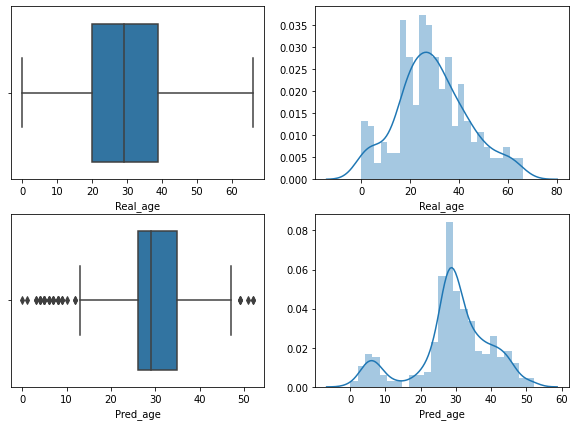

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))

sns.boxplot(ax=axes[0][0], x='Real_age', data=pred)
sns.boxplot(ax=axes[1][0], x='Pred_age', data=pred)
sns.distplot(pred['Real_age'], ax=axes[0][1], bins=25)
sns.distplot(pred['Pred_age'], ax=axes[1][1], bins=25)

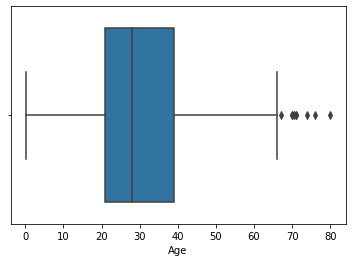

In [22]:
plt.hist(x = [data1[data1['Survived']==1]['Age'], data1[data1['Survived']==0]['Age']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])

### Predict Age Real

In [23]:
model = clf_age.predict(x_ageTest)
model = [np.intc(x) for x in model]
dfAgeTest.Age = model

/home/ds_magico/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


# Survived

In [43]:
df_4 = pd.concat([dfAgeTest, dfAgeTrain]).sort_values(by='PassengerId')

df_4.Age = df_4.Age.astype(int) #[np.intc(i) for i in df_4.Age]

### col family_sex

### col family_size
# df_4['Family_size'] = [ i for i in df_4.SibSp + df_4.Parch]

### col sex
# sex = [[1, 0] if 1 == i else [0, 1] for i in df_4.Sex]
# sex = pd.DataFrame(sex)
# sex.columns = ['Male', 'Female']
# df_4 = df_4.join(sex)

### col names_num
# df_4['Names_num'] = [len(i.split()) for i in df_4.Name]

### col Age
# df_4.loc[ df_4['Age'] <= 23, 'Age'] = 0
# df_4.loc[(df_4['Age'] > 23) & (df_4['Age'] <= 34), 'Age'] = 1
# # df_4.loc[(df_4['Age'] > 28) & (df_4['Age'] <= 37), 'Age'] = 2
# # df_4.loc[(df_4['Age'] > 31) & (df_4['Age'] <= 41), 'Age'] = 3
# df_4.loc[ df_4['Age'] > 34, 'Age'] = 2;

### col Alone, max 2 
# 0 if i < 1 else 1 if i == 1 else 2
df_4['Alone'] = [0 if i == 0 else 1 for i in df_4.SibSp + df_4.Parch]


#
df_4.Cabin = df_4.Cabin.astype(int)
df_4 = df_4[df_4.Embarked < 6]

In [44]:
pd.crosstab( df_4.Embarked, df_4.Survived, normalize='all') * 100

Survived,0.0,1.0
Embarked,,
0,47.923681,24.354658
1,8.417508,10.437710
2,5.274972,3.591470


In [45]:
df_4.describe()

,Age,Cabin,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Title,Min,Per_25,Per_50,Pre_75,Max,Std,Alone
count,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000,1309.000000
mean,29.747135,0.805959,0.397250,33.295479,0.385027,655.000000,2.294882,0.644003,0.498854,0.383838,2.658518,11.627196,9.064171,21.697479,28.310924,38.392666,72.722689,0.396486
std,13.494458,0.395612,0.656321,51.738879,0.865560,378.020061,0.837836,0.478997,1.041658,0.486592,1.134784,1.686897,5.527704,5.947669,7.055614,8.489613,14.559546,0.489354
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,4.000000,0.000000,2.000000,4.000000,9.000000,14.000000,0.000000
25%,22.000000,1.000000,0.000000,7.895800,0.000000,328.000000,2.000000,0.000000,0.000000,0.000000,2.000000,12.000000,11.000000,24.000000,30.000000,41.000000,70.000000,0.000000
50%,28.000000,1.000000,0.000000,14.454200,0.000000,655.000000,3.000000,1.000000,0.000000,0.000000,2.000000,12.000000,11.000000,24.000000,30.000000,41.000000,80.000000,0.000000
75%,37.000000,1.000000,1.000000,31.275000,0.000000,982.000000,3.000000,1.000000,1.000000,1.000000,3.000000,12.000000,11.000000,24.000000,30.000000,41.000000,80.000000,1.000000
max,80.000000,1.000000,2.000000,512.329200,9.000000,1309.000000,3.000000,1.000000,8.000000,1.000000,5.000000,12.000000,23.000000,32.000000,44.000000,53.000000,80.000000,1.000000


(array([[ 37.,  15.,  63.,  93.,  65.,  31.,  26.,  11.,   0.,   1.],
        [ 57.,  39., 179., 270., 159.,  94.,  54.,  26.,  11.,   2.]]),
 array([ 0.,  8., 16., 24., 32., 40., 48., 56., 64., 72., 80.]),
 <a list of 2 Lists of Patches objects>)

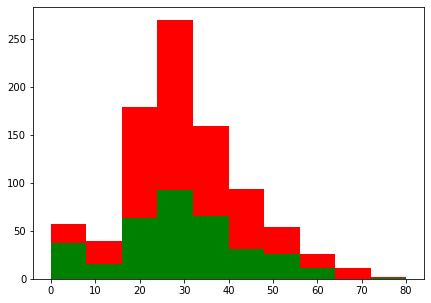

In [53]:
plt.figure(figsize=(7, 5))
plt.hist(x = [df_4[df_4['Survived']==1]['Age'], df_4[df_4['Survived']==0]['Age']], stacked=True, color = ['g','r'],label = ['Survived','Dead'])

NameError: name 'axis1' is not defined

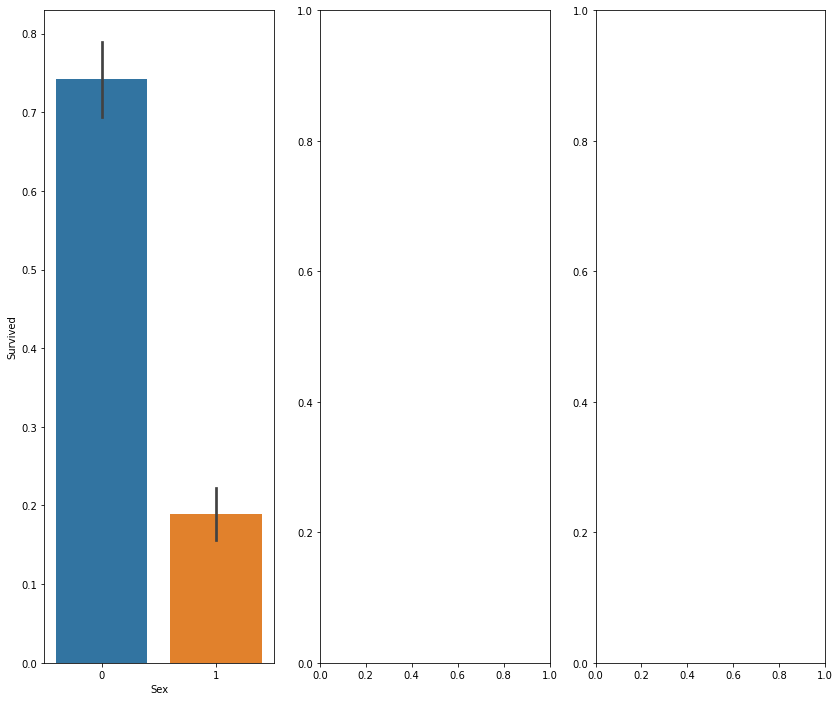

In [61]:
fig, qaxis = plt.subplots(1,3,figsize=(14,12))

sns.barplot(x = 'Sex', y = 'Survived', data=df_4, ax = qaxis[0])
axis1.set_title('Sex vs Embarked Survival Comparison')

sns.barplot(x = 'Sex', y = 'Survived', data=df_4, ax  = qaxis[1])
axis1.set_title('Sex vs Pclass Survival Comparison')


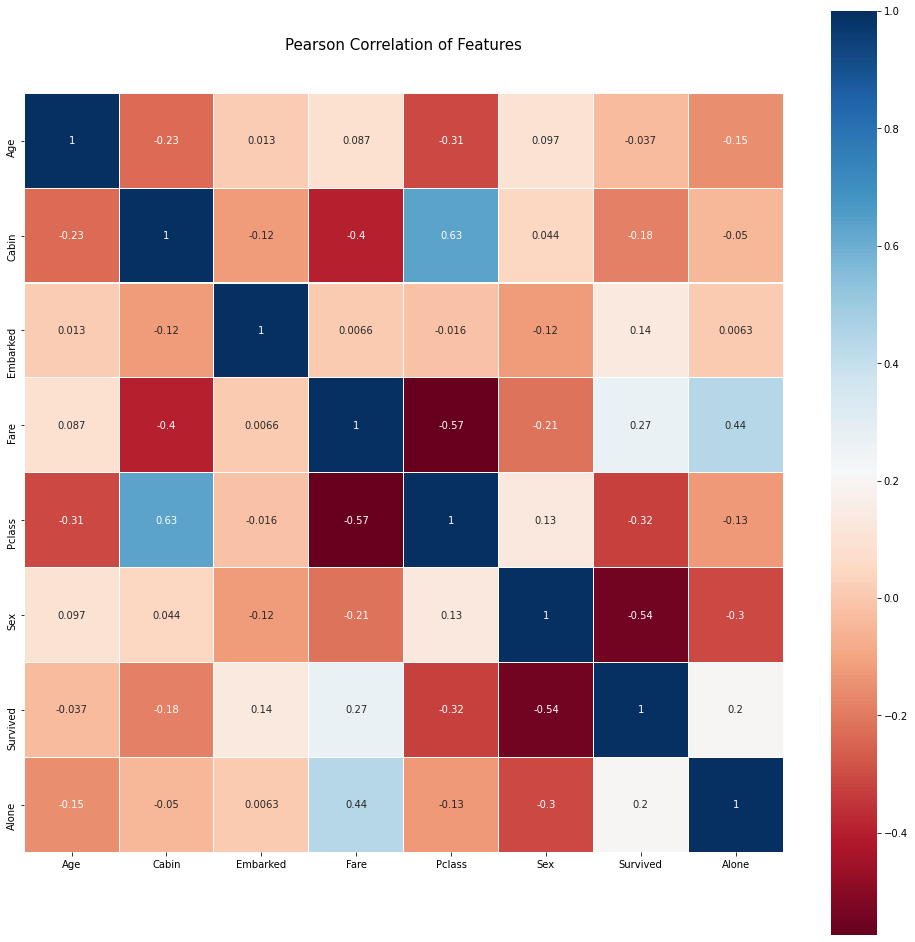

In [30]:
df_4 = df_4[~df_4.Survived.isna()].drop(columns=['Std', 'Min' ,'Per_25', 'Per_50', 'Pre_75', 'Max','Ticket', 'PassengerId', 'Name', 'Title', 'SibSp', 'Parch'])
df_4.Survived = df_4.Survived.astype(int)
# df_4.Survived = [ np.intc(i) for i in df_4.Survived]

y = df_4.Survived
x = df_4.drop(columns='Survived')

colormap = plt.cm.RdBu
plt.figure(figsize=(17,17))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df_4.astype(float).corr(method='kendall') ,linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

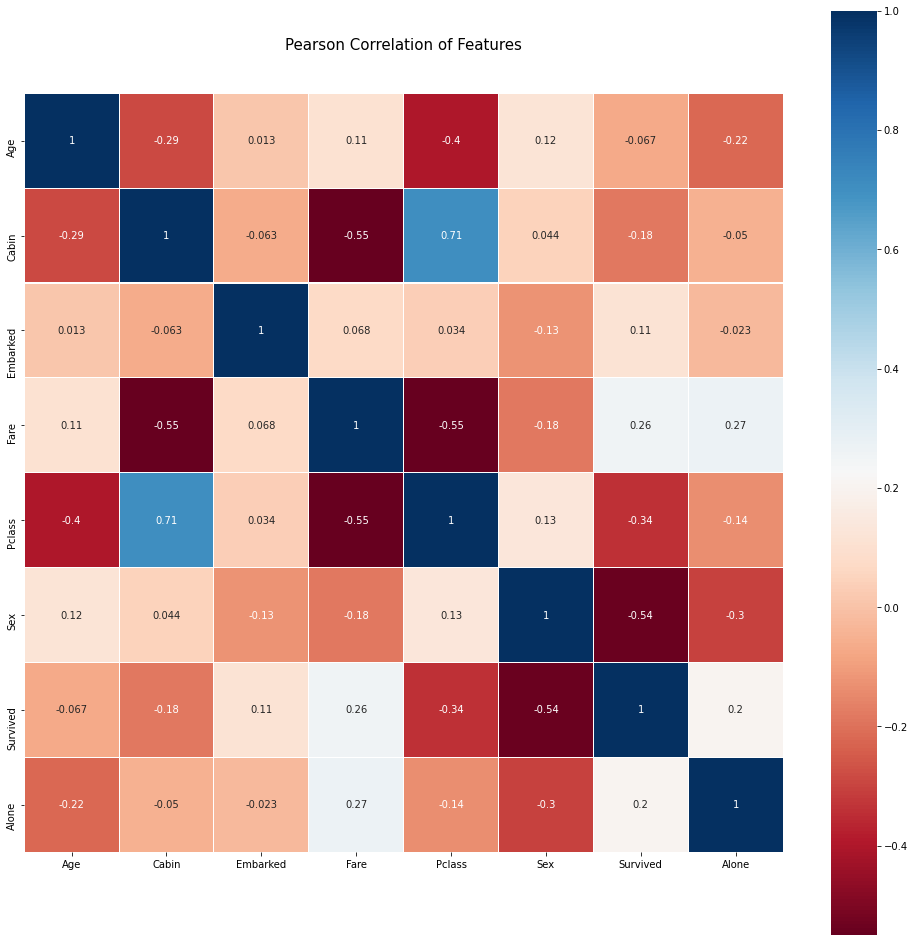

In [31]:
colormap = plt.cm.RdBu
plt.figure(figsize=(17,17))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df_4.astype(float).corr() ,linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [41]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=337)

# RandomForestClassifier
# GaussianProcessClassifier
# GradientBoostingClassifier
# AdaBoostClassifier
# RidgeClassifierCV
# RidgeClassifier
# BaggingClassifier
# ExtraTreesClassifier
# RandomForestClassifier
# BernoulliNB
# LinearDiscriminantAnalysis
# XGBClassifier 

# import autosklearn.classification
# cls = autosklearn.classification.AutoSklearnClassifier()
# cls.fit(x_train, y_train)

clf = XGBClassifier(
        learning_rate = 0.15,
         n_estimators= 2000,
         max_depth= 1,
         min_child_weight= 1,
         #gamma=1,
         gamma=0.9,                        
         subsample=0.79,
         colsample_bytree=0.8,
         objective= 'binary:logistic',
         nthread= -1,
         scale_pos_weight=1
      )
clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
accuracy_score(y_test, y_pred) * 100

79.8507462686567